Sending request... Endpoint :  http://7002b687-b98b-438a-a23a-7537b4ddf682.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


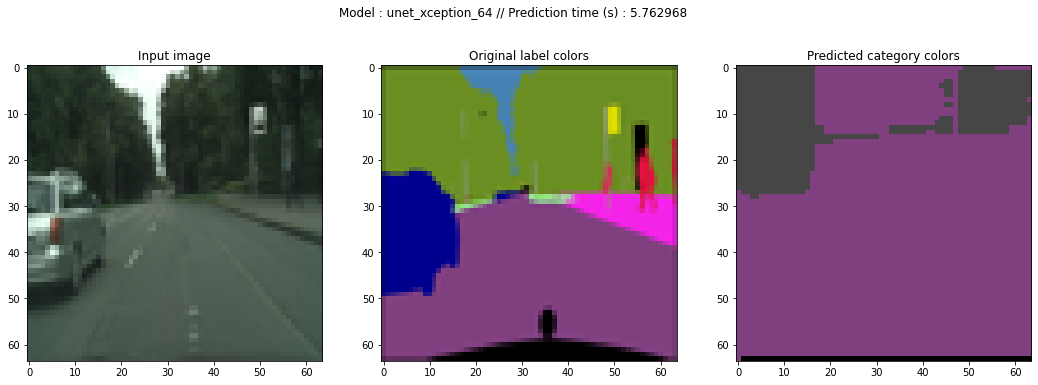

Sending request... Endpoint :  http://1c267ea6-8080-433b-9e62-37496722ae70.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


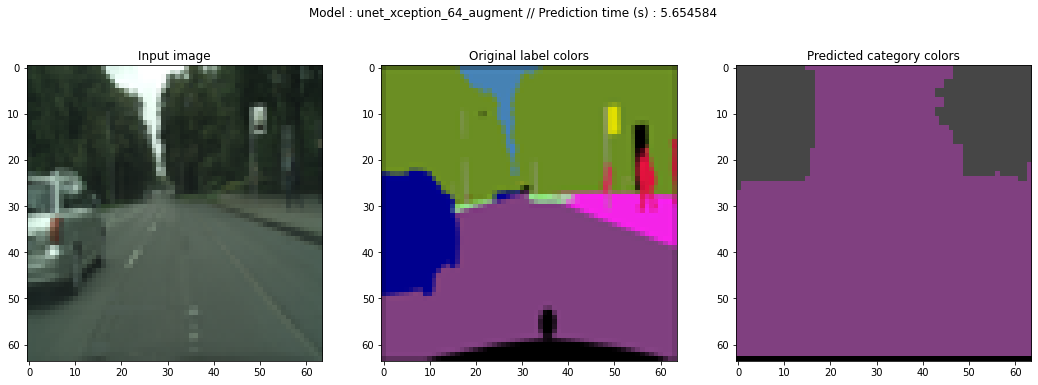

Sending request... Endpoint :  http://f636ee53-2141-4e81-8514-6f20a86d37a5.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


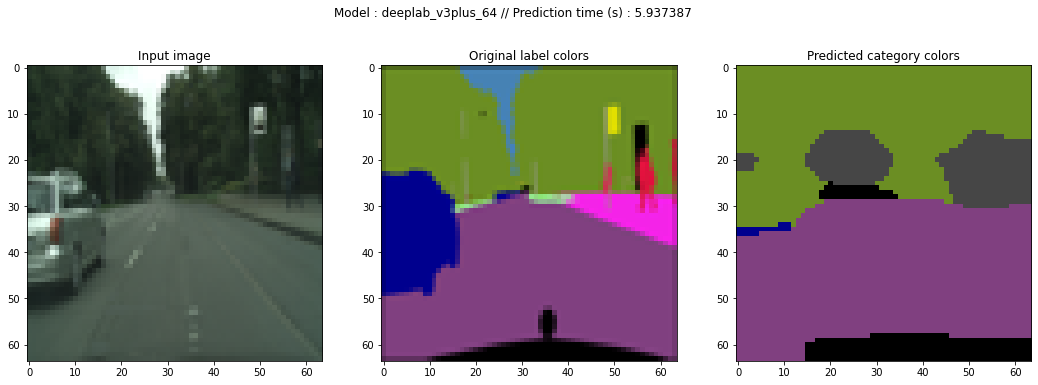

Sending request... Endpoint :  http://7a272df9-b557-4b88-b8da-12789cfd2a20.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


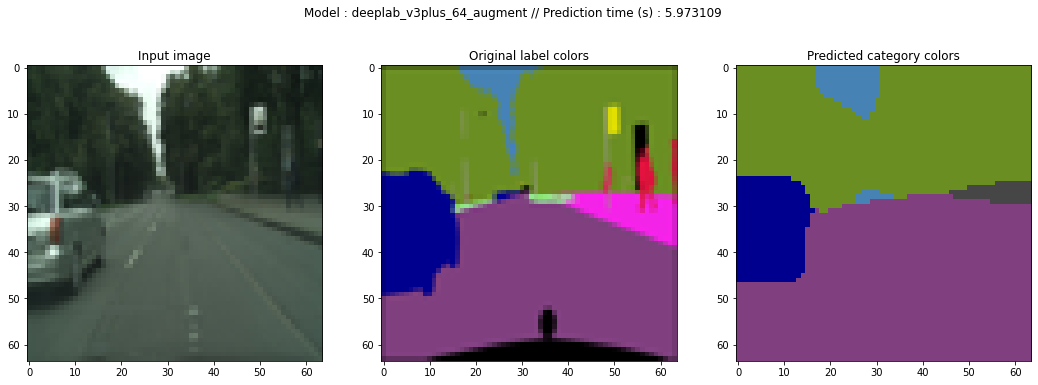

Sending request... Endpoint :  http://6c697657-9382-4fc0-ac91-058ce64a42ad.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


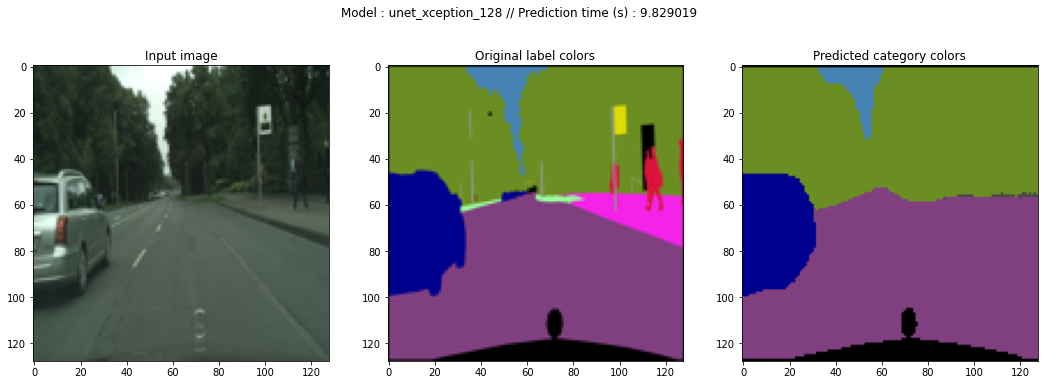

Sending request... Endpoint :  http://b20853c8-7b06-4812-a3c1-56af5caef778.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


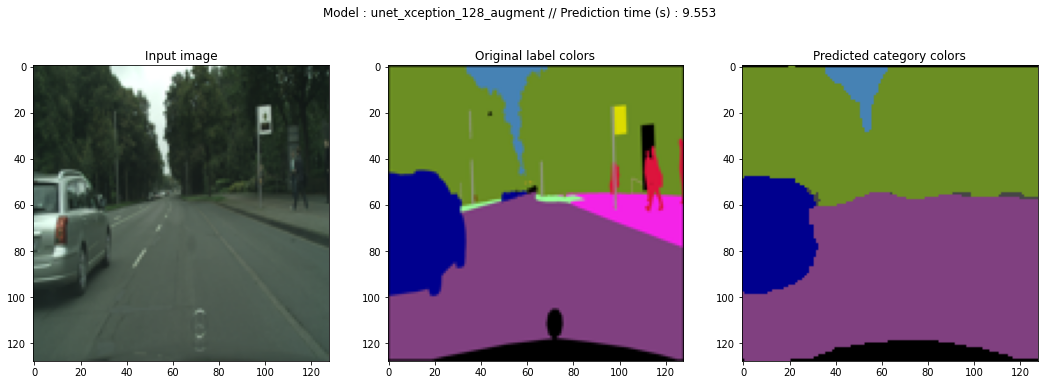

Sending request... Endpoint :  http://fd35ef7f-aa6e-46bf-bc58-02e756ee0359.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


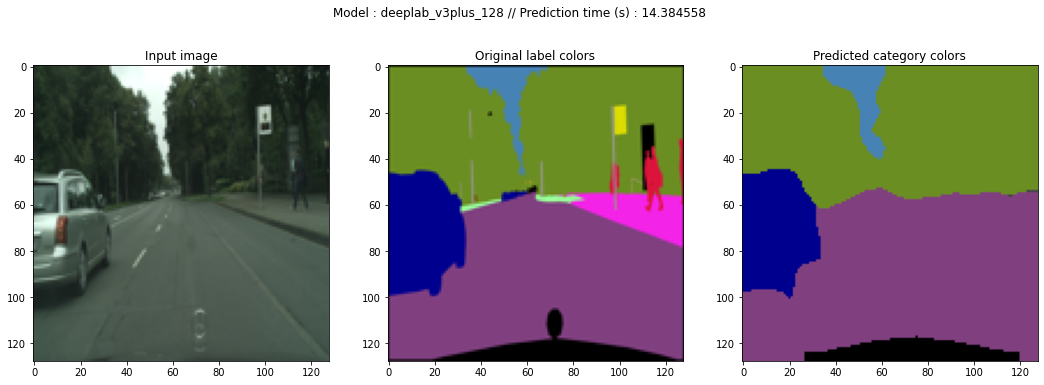

Sending request... Endpoint :  http://4111c9be-b304-4a88-a572-fc19dea30890.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


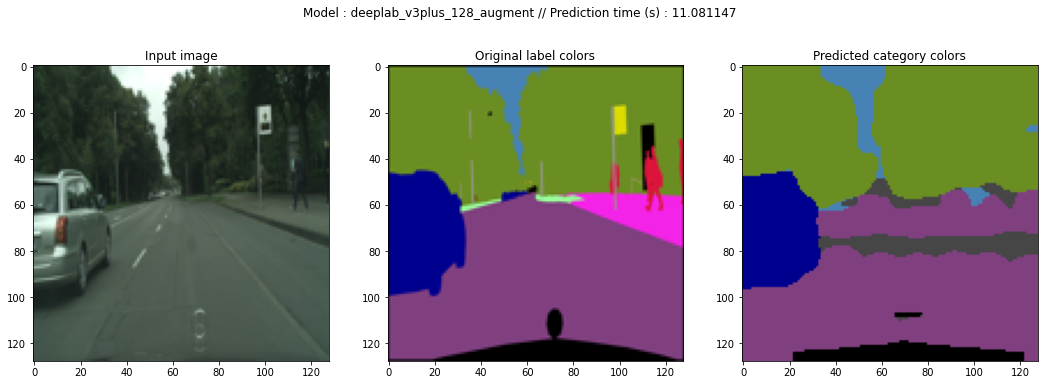

Sending request... Endpoint :  http://bc0c2b50-36ef-4989-bc05-7001e407b847.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


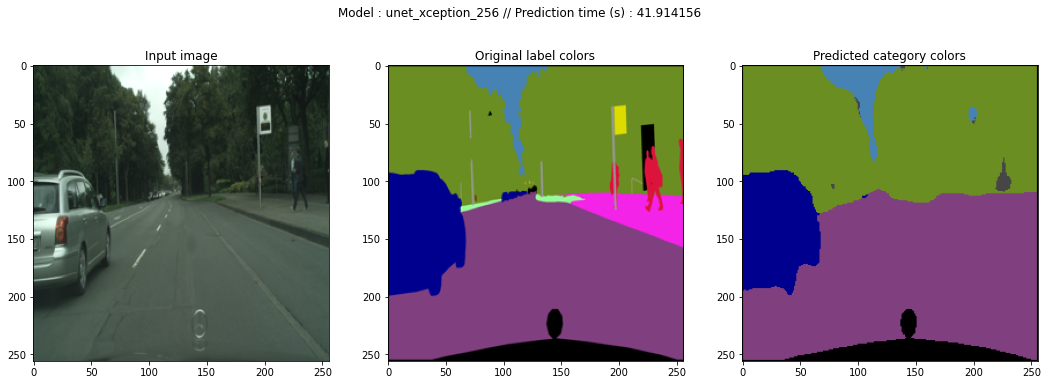

Sending request... Endpoint :  http://72fb1d90-ed0b-4171-a725-1444f9b33809.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


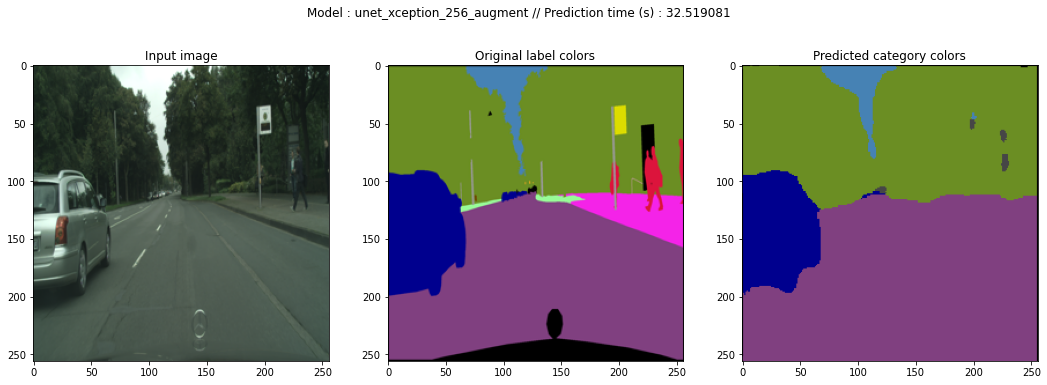

Sending request... Endpoint :  http://ad112f56-bbf7-45d3-a215-05bae31ccfbc.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


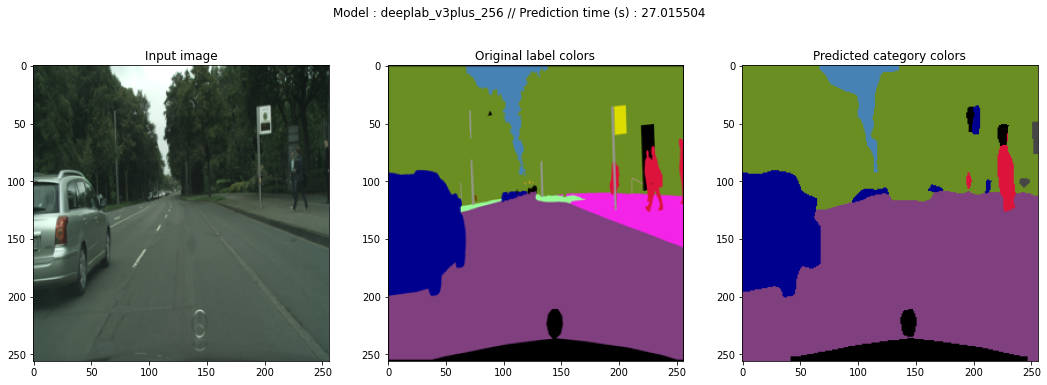

Sending request... Endpoint :  http://44627385-81a8-4cc4-8f3c-9497fda8ed09.westeurope.azurecontainer.io/score
Response recieved... Status code :  200


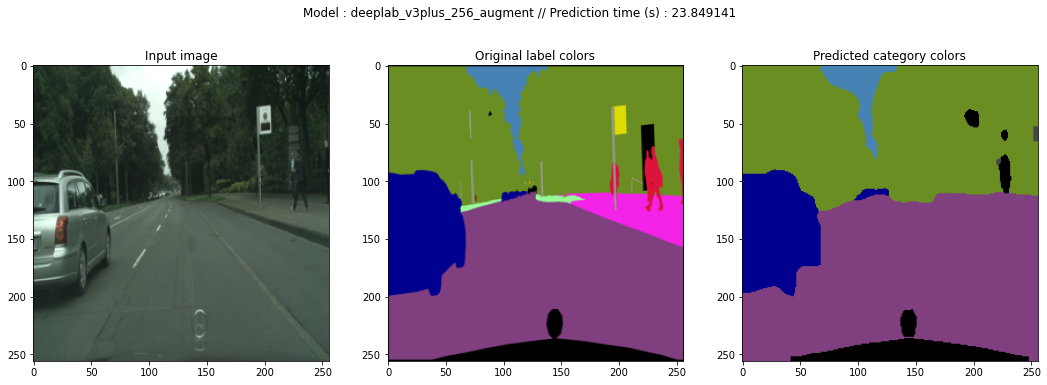

Sending request... Endpoint :  http://aafb2f09-357f-400b-8aa7-1938cc92bfb3.westeurope.azurecontainer.io/score
Response recieved... Status code :  504


Error: Invalid base64-encoded string: number of data characters (93) cannot be 1 more than a multiple of 4

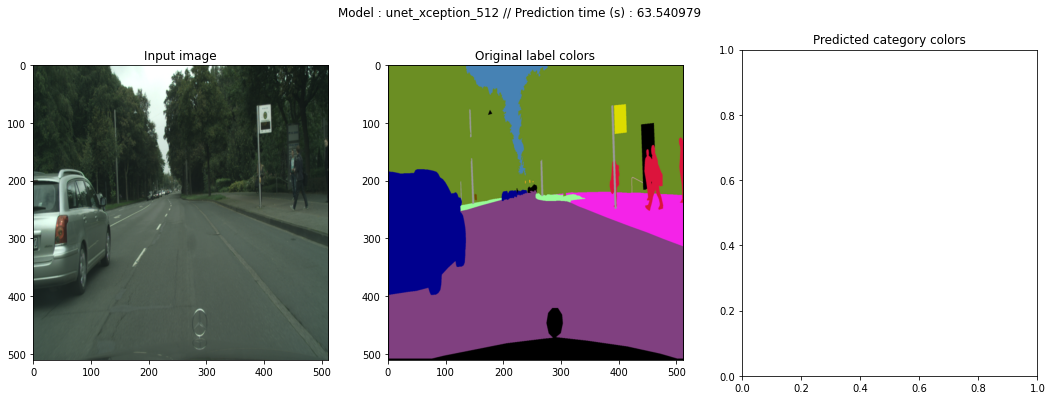

In [3]:
import base64
import json
from io import BytesIO
from pathlib import Path

import numpy as np
import requests
from dotenv import dotenv_values
from matplotlib import pyplot as plt
from PIL import Image


model_choices = [
    "unet_xception",
    "deeplab_v3plus",
    # "fcn_8",
]
augment_choices = [
    False,
    True,
]
resize_choices = [
    64,
    # 80,
    128,
    # 160,
    256,
    # 320,
    512,
    # 640,
]


# Get the images
raw_data_path = Path("./../data/raw")
leftImg8bit_path = Path(raw_data_path, "leftImg8bit")
gtFine_path = Path(raw_data_path, "gtFine")

# Validation dataset
val_input_img_paths = sorted(
    Path(leftImg8bit_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_colors_img_paths = sorted(
    Path(gtFine_path, "val").glob("**/*_color.png")
)

# Get a random image index
rand_idx = np.random.randint(0, len(val_input_img_paths))


with open(val_input_img_paths[rand_idx], "rb") as f:
    im_read = f.read()
    im_b64 = base64.b64encode(im_read)
    im_b64_str = im_b64.decode("utf-8")

    # Request data goes here
    data = {"image": im_b64_str}
    payload = str.encode(json.dumps(data))


    for resize in resize_choices:
        for model in model_choices:
            for augment in augment_choices:
                model_name = f"{model}_{resize}{'_augment' if augment else ''}"
                
                # Set the model input size
                model_input_size = int(
                    model_name.replace("_augment", "").split("_")[-1]
                )
                img_size = (model_input_size, model_input_size)

                # Call the inference endpoint
                inference_config = dotenv_values(Path(f"../.env.{model_name}"))
                url = inference_config["AZURE_INFERENCE_ENDPOINT"]
                headers = {
                    "Content-Type": "application/json",
                    "Authorization": (
                        "Bearer " + inference_config["AZURE_INFERENCE_KEY"]
                    ),
                }

                print("Sending request... Endpoint : ", url)
                r = requests.post(url, headers=headers, data=payload)
                print("Response recieved... Status code : ", r.status_code)
                result = r.content
                time = r.elapsed.total_seconds()

                # Plot the image, ground truth and prediction
                fig, ax = plt.subplots(
                    nrows=1,
                    ncols=3,
                    figsize=(18, 6),
                )
                fig.suptitle(f"Model : {model_name} // Prediction time (s) : {time}")

                ax[0].title.set_text("Input image")
                val_img = Image.open(val_input_img_paths[rand_idx]).resize(img_size)
                ax[0].imshow(val_img)

                ax[1].title.set_text("Original label colors")
                val_colors = Image.open(val_label_colors_img_paths[rand_idx]).resize(
                    img_size
                )
                ax[1].imshow(val_colors)

                ax[2].title.set_text("Predicted category colors")
                ax[2].imshow(Image.open(BytesIO(base64.b64decode(result))))

                plt.show()
